In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [97]:
fname = '../data/OpenEphys_data/100_CH28_sorted.mat'
# fname = '../data/OpenEphys_data/2019-04-02/105_CH4_sorted.mat'
fname = '../data/OpenEphys_data/2019-04-26/2019-04-26_13-45-33/mat_files/101_CH7_sorted.mat'

In [98]:
f = h5py.File(fname)

In [99]:
Fs = 30000.0

In [100]:
list(f.keys())

[u'#refs#', u'CS_data', u'SS_data', u'ch_data']

In [101]:
CS_data = f['CS_data']
SS_data = f['SS_data']
ch_data = f['ch_data']

In [102]:
# plt.figure()
# plt.plot(ch_data_hipass)

In [103]:
list(ch_data)

[u'ch_data_cmn', u'ch_data_hipass', u'ch_data_lopass', u'ch_data_time']

In [104]:
for key,val in ch_data.items():
    valval = np.squeeze(val.value)
    exec(key + '=valval')



In [105]:
# plt.figure(figsize=(10,5))
# ax1 = plt.subplot(211)
# plt.plot(ch_data_time, ch_data_hipass)
# plt.subplot(212, sharex=ax1)
# plt.plot(ch_data_time, ch_data_cmn)


In [106]:
import gc
gc.collect()

150

In [107]:
from kaveh.sorting.spikesorter import SimpleSpikeSorter
dt = 1.0/Fs

In [108]:
sss = SimpleSpikeSorter(ch_data_hipass, dt)

In [109]:
sss._pre_process()

In [110]:
sss._detect_spikes_minibatch()

Using minibatch spike detection, batch size = 50s


In [111]:
sss._align_spikes()


In [112]:
sss.cs_num_gmm_components = 5

In [113]:
sss._cluster_spike_by_feature()


In [114]:
sss._cs_post_process()
print(sss.cs_indices.shape)

(1014,)


In [116]:
ch_data_cmn.shape[0]*dt

346.624

In [117]:
from sklearn.mixture import GaussianMixture

pre_time = 0.0005
post_time = 0.005

pre_index = int(np.round(pre_time/sss.dt))
post_index = int(np.round(post_time/sss.dt))
aligned_cs = np.array([sss.voltage[i - pre_index : i + post_index] for i in sss.cs_indices])


import random

ss_indices = np.setdiff1d(sss.spike_indices, sss.cs_indices)
aligned_ss = np.array([sss.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])


mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), sss.cs_indices.size), ], axis=0)

In [124]:
num_clusters = 4
gmm = GaussianMixture(num_clusters, covariance_type = 'full').fit(aligned_cs)

cluster_labels = gmm.predict(aligned_cs)

clusters = []
for cn in np.arange(num_clusters):
    clusters.append(aligned_cs[np.where(cluster_labels == cn)])
    

<IPython.core.display.Javascript object>


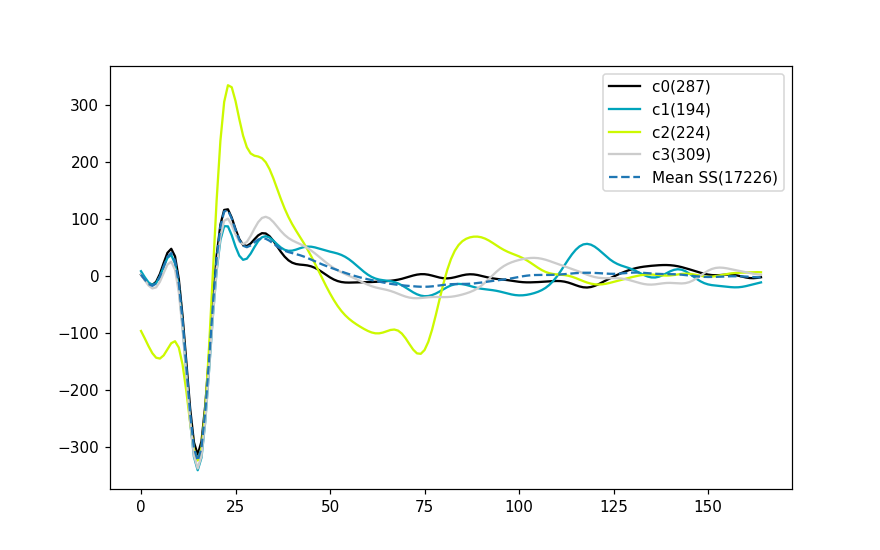

In [125]:
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
# ax2 = plt.subplot(122)
for cn in np.arange(num_clusters):
    plt.plot(np.mean(clusters[cn], axis=0), color = colors[cn], label = legend_labels[cn])
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
# plt.show()    
plt.legend() 

In [252]:
cs_indices = sss.cs_indices[np.where(np.logical_or(cluster_labels == 0, cluster_labels == 1))]
# cs_indices = sss.cs_indices[np.where(cluster_labels == 1)]

In [120]:
clusters_to_pick = [4]
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, sss.cs_indices[np.where(cluster_labels == cti)])

In [121]:
cs_indices = cs_indices_to_pick
cs_indices.shape

(222,)

In [122]:
CS_csv_filename = fname + '.CS.csv'
SS_csv_filename = fname + '.SS.csv'
xcor_filename = fname + '.xcor.pny'
acor_filename = fname + '.acor.pny'

In [123]:
import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

writing ../data/OpenEphys_data/2019-04-26/2019-04-26_13-45-33/mat_files/101_CH7_sorted.mat.CS.csv ... 
writing ../data/OpenEphys_data/2019-04-26/2019-04-26_13-45-33/mat_files/101_CH7_sorted.mat.SS.csv ... 


In [257]:
SS = np.zeros(np.int64(ch_data_hipass.size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(ch_data_hipass.size/30.0))
CS[np.int64(cs_indices/30.0)] = 1

In [258]:
# SS = np.zeros(ch_data_hipass.size)
# SS[ss_indices] = 1
# CS = np.zeros(ch_data_hipass.size)
# CS[cs_indices] = 1


<IPython.core.display.Javascript object>


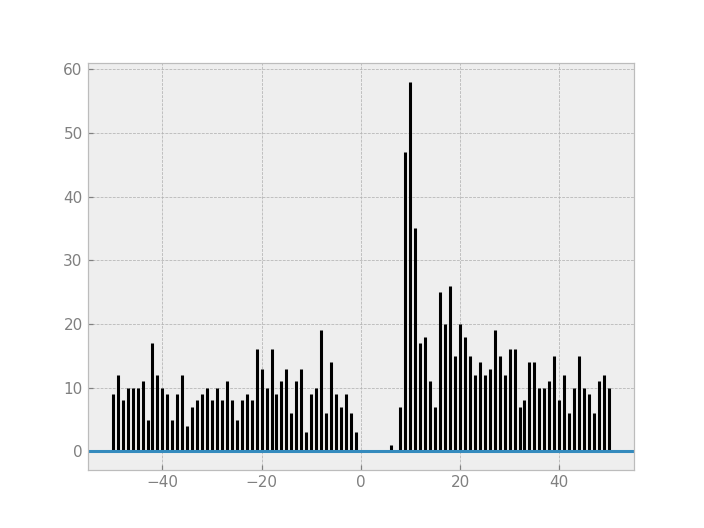

In [259]:
plt.figure()
xcor_ret = plt.xcorr(SS, CS, usevlines=True, maxlags=50, normed=False, lw=2)

<IPython.core.display.Javascript object>


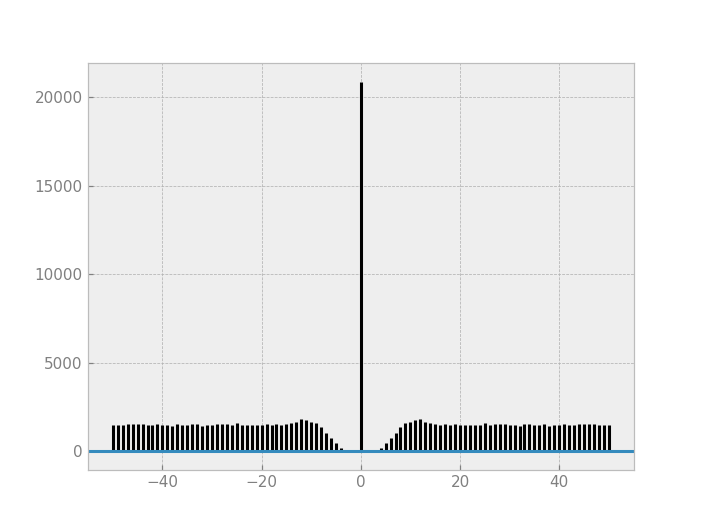

In [260]:
plt.figure()
acor_ret = plt.acorr(SS, usevlines=True, maxlags=50, normed=False, lw=2)

In [265]:
acor_ret[1][50]=0

In [266]:
from matplotlib import style

style.use('bmh')
COLOR = 'gray'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

<IPython.core.display.Javascript object>


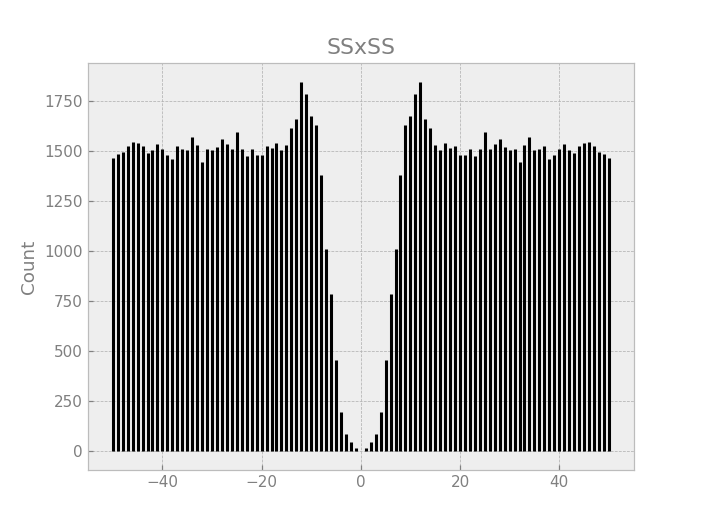

Text(0,0.5,u'Count')

In [267]:
plt.figure()
plt.vlines(acor_ret[0], 0, acor_ret[1])
plt.title('SSxSS')
plt.ylabel('Count')

<IPython.core.display.Javascript object>


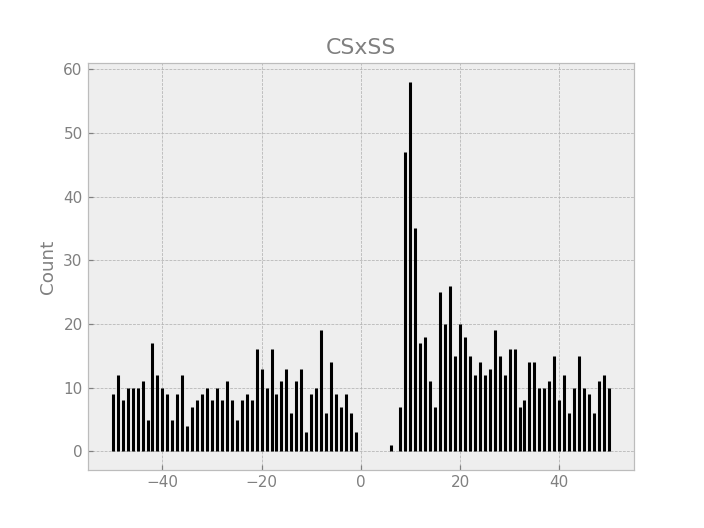

Text(0,0.5,u'Count')

In [263]:
plt.figure()
plt.vlines(xcor_ret[0], 0, xcor_ret[1])
plt.title('CSxSS')
plt.ylabel('Count')

<IPython.core.display.Javascript object>


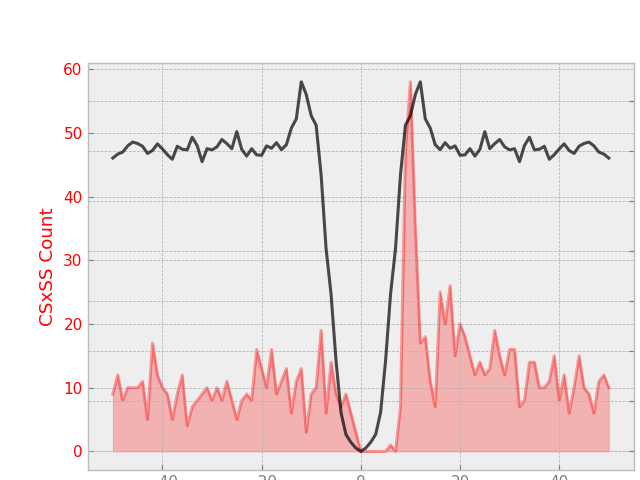

Text(0,0.5,u'SSxSS Count')

In [268]:
plt.figure()
plt.plot(xcor_ret[0], xcor_ret[1], 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(xcor_ret[0], 0, xcor_ret[1] , color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_ret[0], acor_ret[1], 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


In [145]:
# np.save('./ch6_12-03-55_xcor.npy', xcor_ret)
# np.save('./ch6_12-03-55_acor.npy', acor_ret)

In [269]:
np.save(xcor_filename, xcor_ret)
np.save(acor_filename, acor_ret)

In [206]:
# tmp = np.load('./test.npy')

In [270]:
plt.savefig(fname + '.png')
plt.savefig(fname + '.svg')

<IPython.core.display.Javascript object>


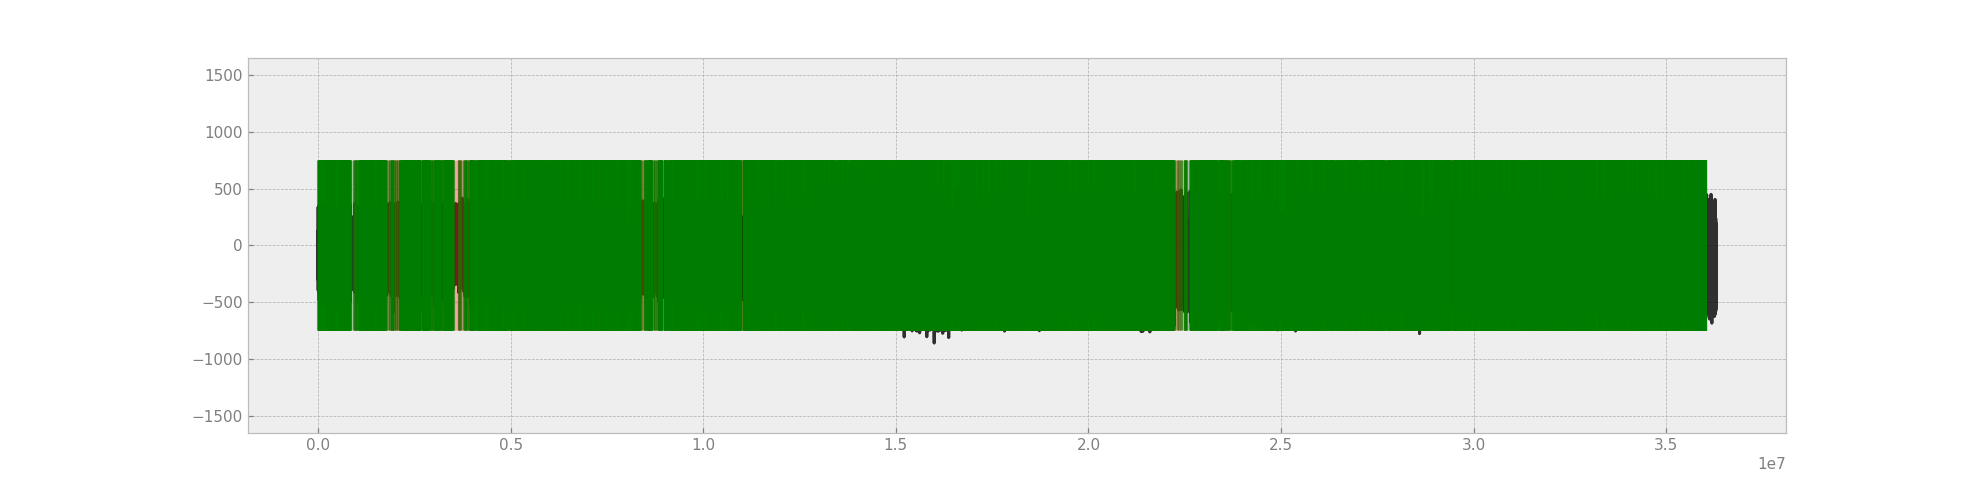

In [205]:
plt.figure()
plt.plot(ch_data_hipass, alpha=0.8, color='k')
plt.eventplot(cs_indices,linelengths=1500 , colors='red', alpha = 0.3 , zorder = 10)
plt.eventplot(ss_indices,linelengths=1500 , colors='g', alpha = 0.3 , zorder = 10)
# plt.xlabel('Time (s)')
plt.show()


In [74]:
np.sum(xcor_ret[1])

5360.0

<IPython.core.display.Javascript object>


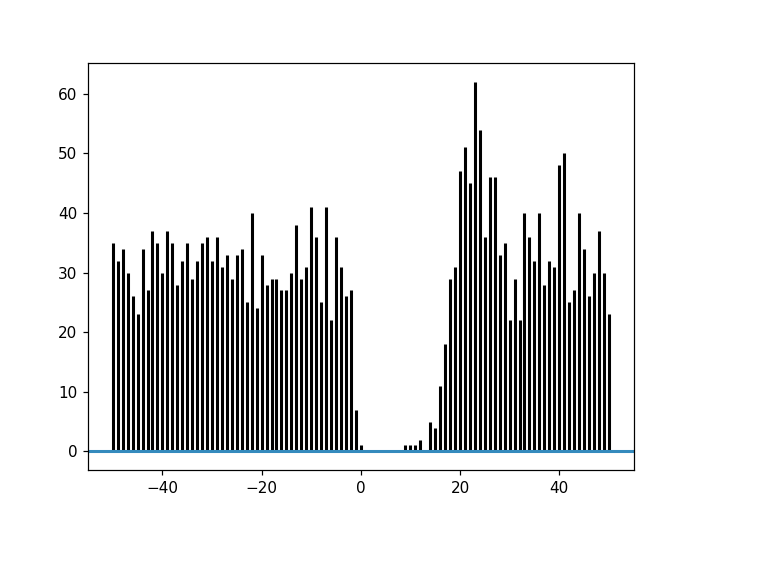

<IPython.core.display.Javascript object>


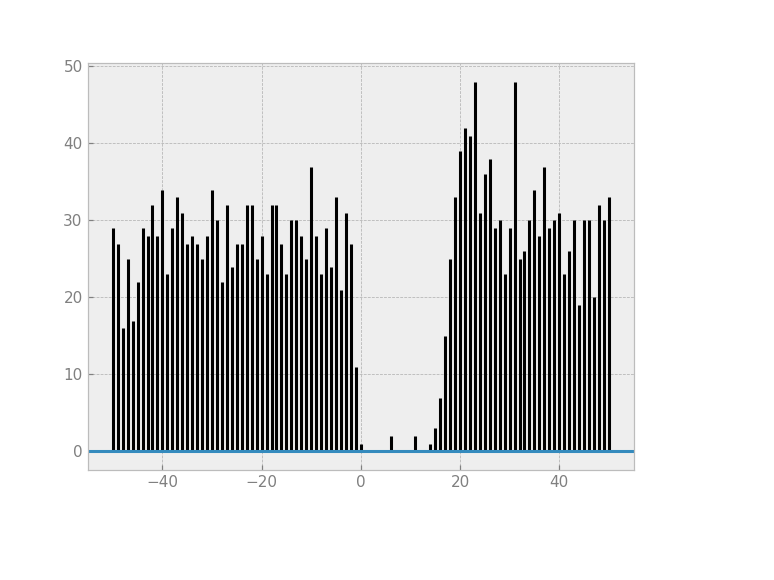

<IPython.core.display.Javascript object>


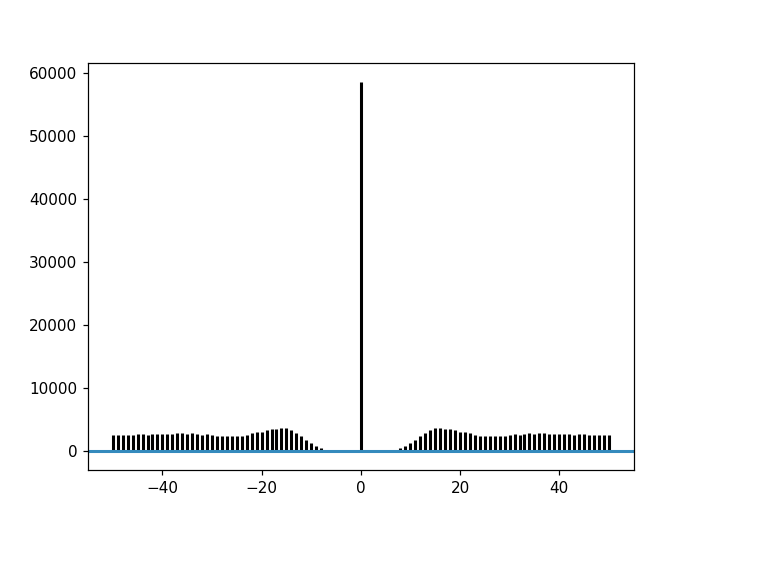

<IPython.core.display.Javascript object>


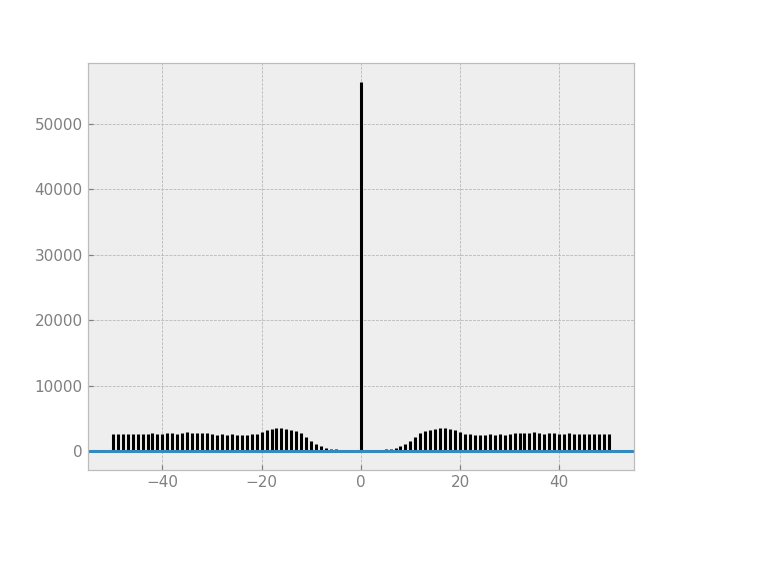

In [165]:
xcorr_1 = np.load('./ch5_xcor.npy')
xcorr_2 = np.load('./ch5_12-03-55_xcor.npy')

acorr_1 = np.load('./ch5_acor.npy')
acorr_2 = np.load('./ch5_12-03-55_acor.npy')

In [162]:
xcorr_x = xcorr_1[0]
xcorr_y = xcorr_1[1]+xcorr_2[1]
acorr_x = acorr_1[0]
acorr_y = acorr_1[1]+acorr_2[1]

<IPython.core.display.Javascript object>


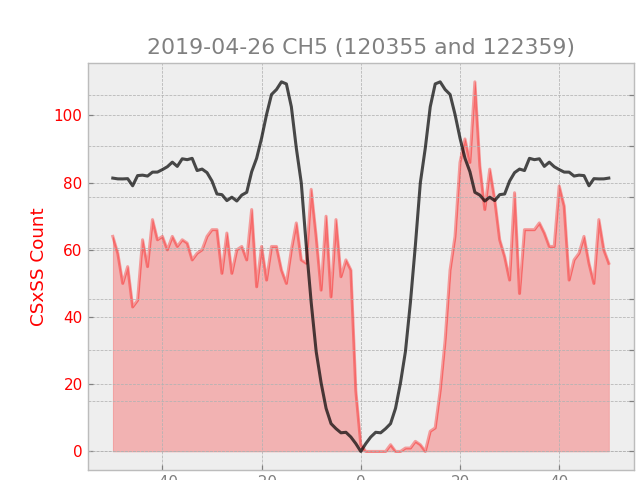

Text(0,0.5,u'SSxSS Count')

In [166]:

plt.figure()
plt.plot(xcorr_x, xcorr_y, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(xcorr_x, 0, xcorr_y , color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')
plt.title('2019-04-26 CH5 (120355 and 122359)')
plt.twinx()
plt.plot(acorr_x, acorr_y, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


In [167]:
plt.savefig('./ch5_2019-04-26.png')
plt.savefig('./ch5_2019-04-26.svg')